# Docutron Toolkit: detection and segmentation analysis for legal data extraction over documents
[![Python](https://img.shields.io/pypi/pyversions/tensorflow.svg)](https://badge.fury.io/py/tensorflow) [![License](https://img.shields.io/badge/License-Apache_2.0-blue.svg)](https://opensource.org/licenses/Apache-2.0) ![Maintainer](https://img.shields.io/badge/maintainer-@louisbrulenaudet-blue)

Docutron is a tool designed to facilitate the extraction of relevant information from legal documents, enabling professionals to create datasets for fine-tuning language models (LLM) for specific legal domains.


# Collecting and installing dependencies

In [4]:
import sys, os, distutils.core

!git clone 'https://github.com/louisbrulenaudet/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

Cloning into 'detectron2'...
remote: Enumerating objects: 15169, done.
remote: Counting objects: 100% (288/288), done.
remote: Compressing objects: 100% (186/186), done.
remote: Total 15169 (delta 149), reused 175 (delta 102), pack-reused 14881
Receiving objects: 100% (15169/15169), 6.27 MiB | 16.64 MiB/s, done.
Resolving deltas: 100% (10960/10960), done.


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=c0717348875bb9b05d5a89fb42e37089dac214f41435ec5924c5ececec974697
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=373a7a4680e4b0b00e6047fd63acaa7cb2286197f321fa863ccc66762d24eddb
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a12

# Importing packages

In [17]:
import cv2
import json
import locale
import numpy as np
import os
import random
import requests
import subprocess
import sys
import uuid
import zipfile
from io import BytesIO

import torch
import distutils.core
import detectron2
from google.colab.patches import cv2_imshow
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

setup_logger()
locale.getpreferredencoding = lambda: "UTF-8"

def hardware_log() -> None:
    """
    Log hardware and software information related to the environment.

    This function prints information about the installed PyTorch
    version, CUDA version, and Detectron2 version.

    Parameters
    ----------
    None

    Returns
    -------
    None

    Example
    -------
    >>> hardware_log()
    torch: 1.9; cuda: 11.1
    detectron2: [detectron2 version]
    """
    !nvcc --version
    TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
    CUDA_VERSION = torch.__version__.split("+")[-1]

    print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
    print("detectron2:", detectron2.__version__)

    return None

hardware_log()

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.1 ; cuda:  cu118
detectron2: 0.6


# Datasets registration

In [20]:
def download_dataset(url: str, destination:str="./") -> None:
    """
    Download and extract a dataset from a specified URL.

    This function fetches a dataset from the provided URL, checks
    the file type, and extracts its contents.

    Parameters
    ----------
    url : str
        The URL of the dataset to download.

    destination : str, optional
        The destination path for the dataset storage.

    Returns
    -------
    None
    """
    response = requests.get(url)

    with zipfile.ZipFile(BytesIO(response.content), 'r') as zip_ref:
        zip_ref.extractall(destination)

    return None


download_dataset(
    url="https://github.com/louisbrulenaudet/docutron/raw/main/datasets.zip"
)

In [49]:
def register_dataset(annotations_path:str, img_dir:str) -> str:
    """
    Register COCO instances for dataset.

    Parameters
    ----------
    annotations_path : str
        The path to the training annotations JSON file.
    img_dir : str
        The directory for the training dataset.

    Returns
    -------
    database_name : str
        The name of the registered training dataset.
    """
    dataset_name = str(uuid.uuid4())

    register_coco_instances(dataset_name, {}, annotations_path, img_dir)

    return dataset_name


dataset_train = register_dataset(
    annotations_path="datasets/train/annotations.json",
    img_dir="datasets/train"
)

dataset_val = register_dataset(
    annotations_path="datasets/val/annotations.json",
    img_dir="datasets/val"
)

In [50]:
def get_metadata(dataset:str) -> any:
    """
    Retrieve metadata for a registered dataset.

    Parameters
    ----------
    dataset : str
        The name of the registered dataset for which metadata is to be retrieved.

    Returns
    -------
    metadata : any
        Metadata associated with the dataset, which may include information about class labels,
        image statistics, and other dataset-specific details.
    """
    metadata = MetadataCatalog.get(dataset)

    return metadata


metadata = get_metadata(dataset=dataset_train)

namespace(name='ef512aef-f21d-4311-aae4-600a617af283',
          json_file='datasets/train/annotations.json',
          image_root='datasets/train',
          evaluator_type='coco')

[10/23 00:25:34 d2.data.datasets.coco]: Loaded 48 images in COCO format from datasets/train/annotations.json


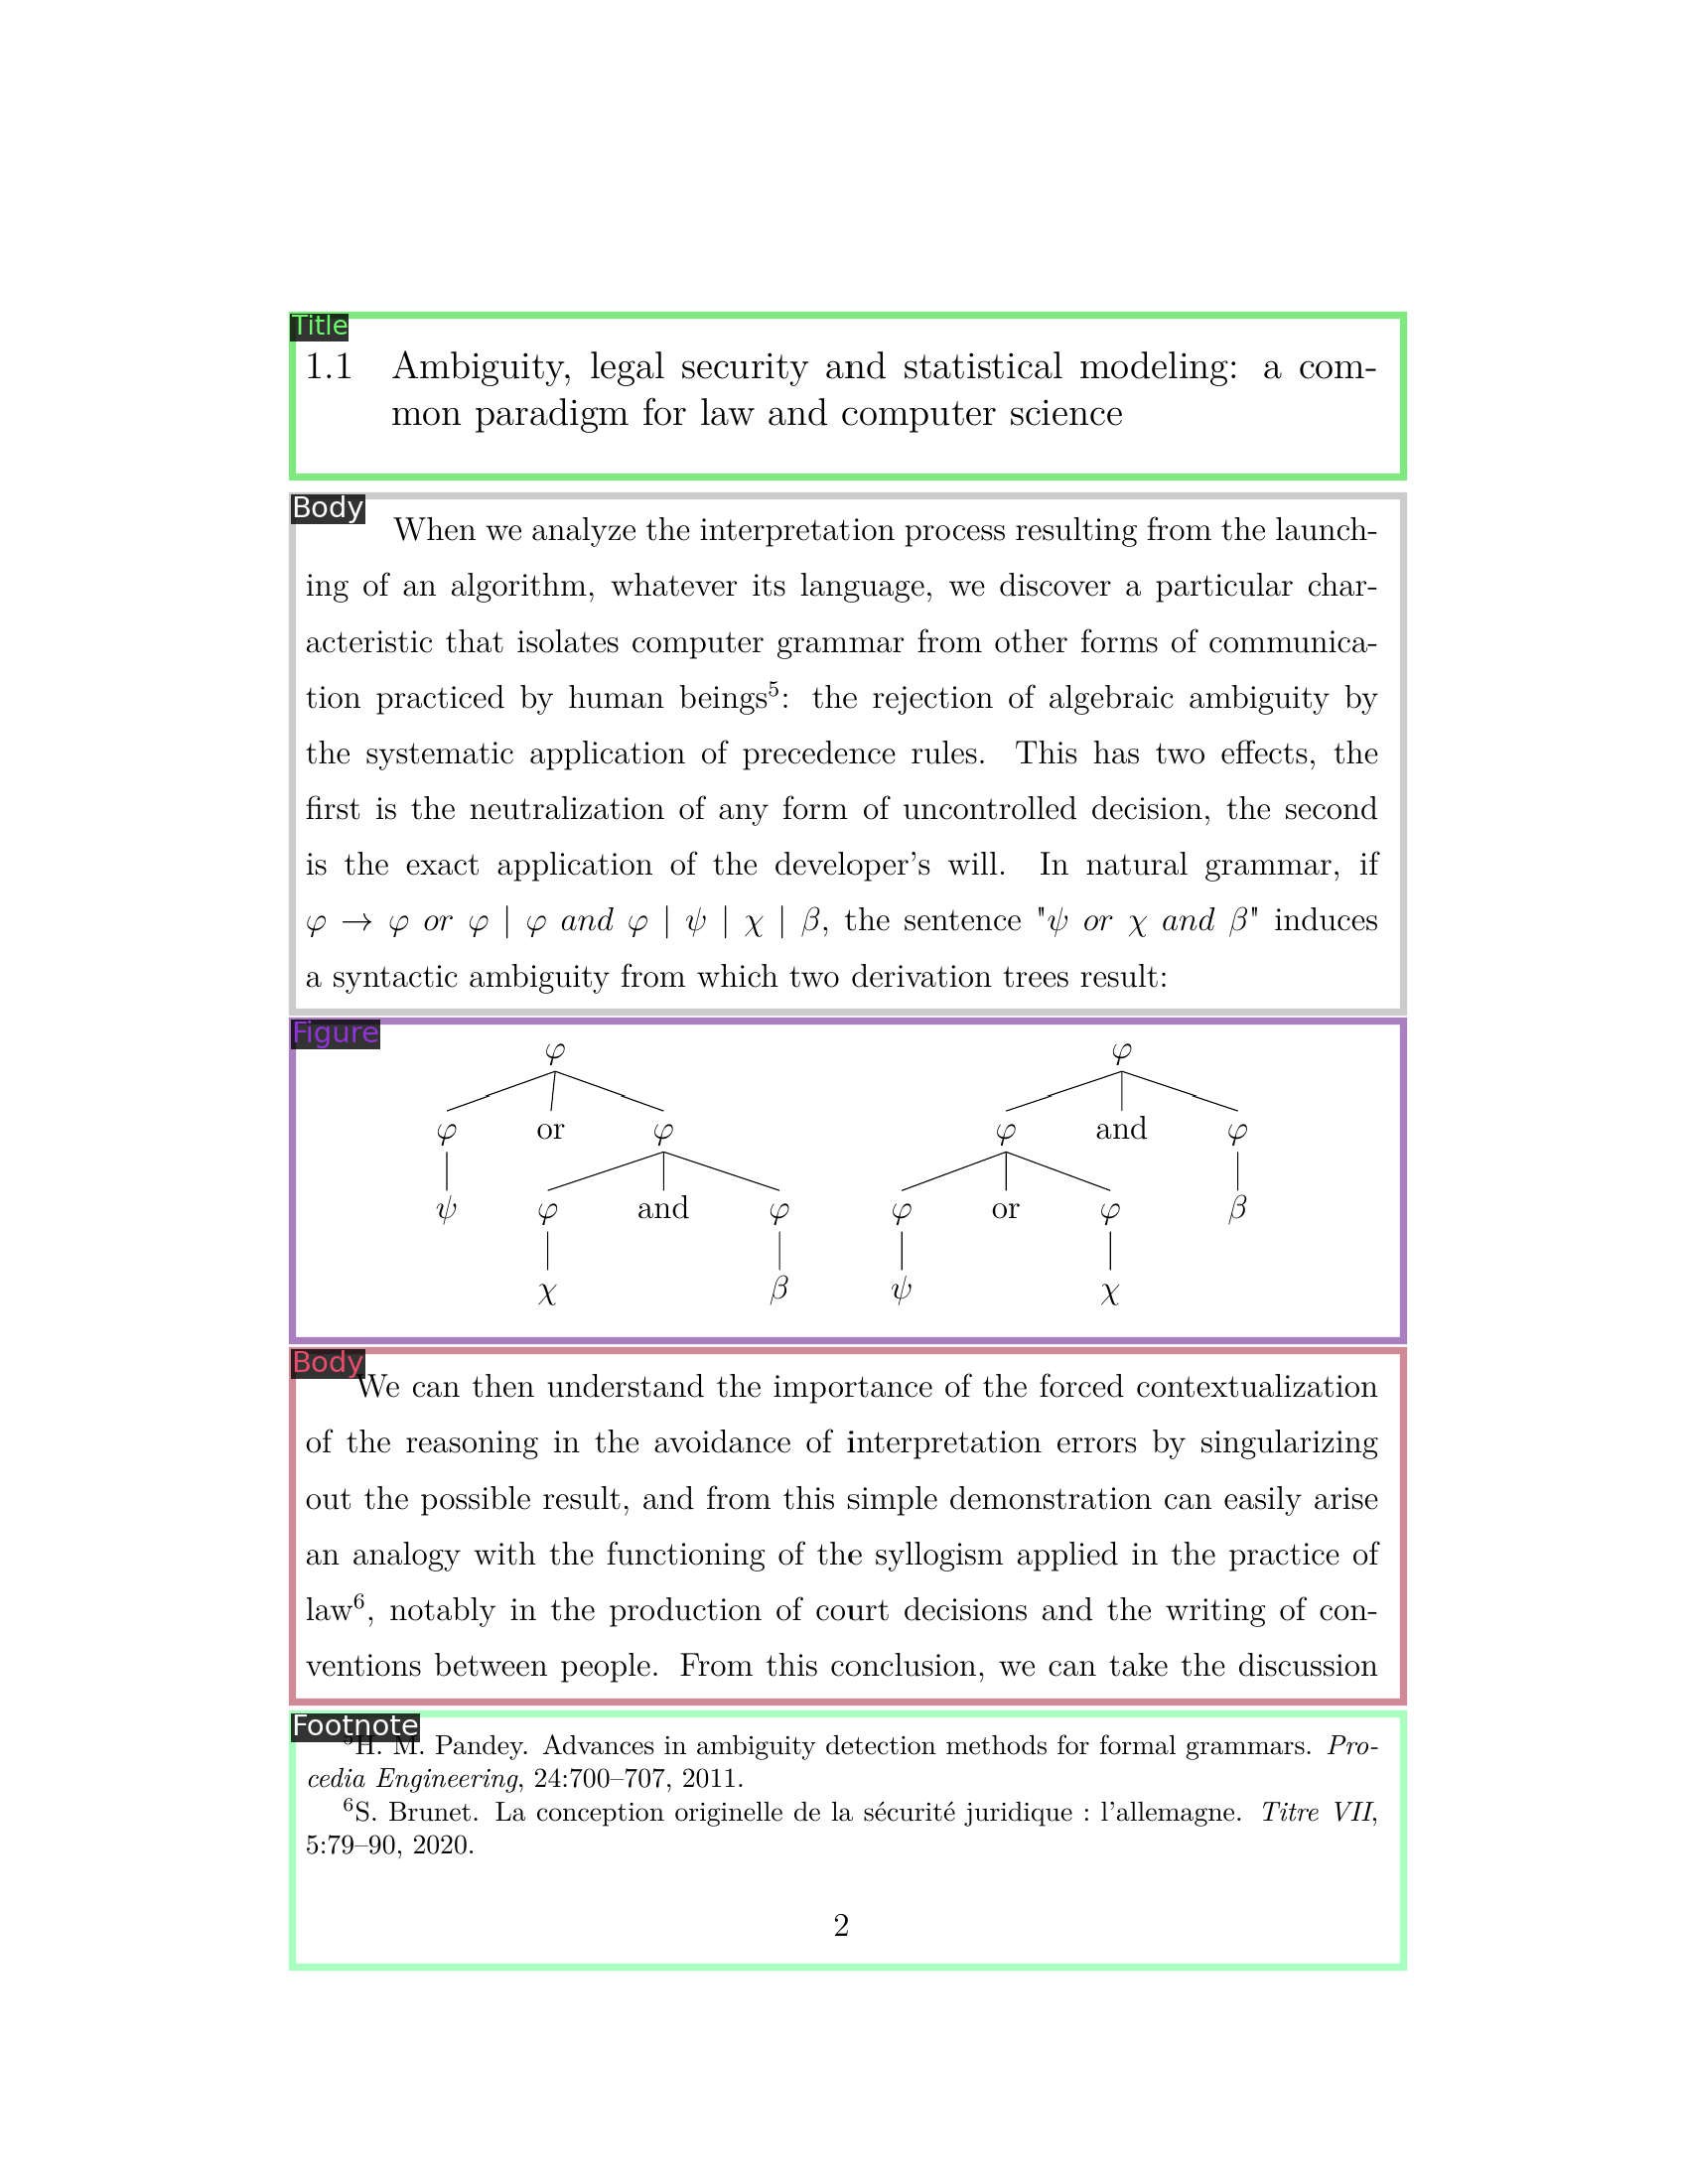

In [51]:
def visualize_dataset_samples(dataset:str, metadata:list, num_samples:int=1, scale:int=1) -> None:
    """
    Visualize random samples from a registered dataset.

    Parameters
    ----------
    dataset : str
        The name of the registered dataset to visualize.

    num_samples : int, optional
        The number of samples to visualize. Default is 1.

    scale : int, optional
        The scale of the test image to be displayed. Default is 1.

    Returns
    -------
    None
    """
    dataset_dicts = DatasetCatalog.get(dataset)

    # Randomly select and visualize dataset samples
    for _ in range(num_samples):
        d = random.choice(dataset_dicts)
        img = cv2.imread(d["file_name"])

        visualizer = Visualizer(
            img[:, :, ::-1],
            metadata=metadata,
            scale=scale
        )

        vis = visualizer.draw_dataset_dict(d)
        cv2_imshow(vis.get_image()[:, :, ::-1])
        cv2.waitKey(0)

    return None


visualize_dataset_samples(dataset=dataset_train, metadata=metadata, num_samples=1)

# Model configuration

In [47]:
def model_configuration(dataset_train, model:str="COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml", device:str="cuda", num_workers:int=2, batch_size:int=2, learning_rate:float=0.00025, iter:int=1000, bs_per_image:int=128, num_classes:int=1) -> any:
    """
    Set up the configuration for the object detection model.

    This function configures the model for training by specifying various
    parameters and settings.

    Parameters
    ----------
    dataset_train : str
        The name of the training dataset to be used for training.

    model : str, optional
        The configuration file for the object detection model. Default is "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml".

    device : str, optional
        The device used for computation. Default is cuda.

    num_workers : int, optional
        The number of data loader workers for training. Default is 2.

    batch_size : int, optional
        The batch size for training. Default is 2.

    learning_rate : float, optional
        The initial learning rate for training. Default is 0.00025.

    iter : int, optional
        The maximum number of training iterations. Default is 1000.

    bs_per_image : int, optional
        The batch size per image for training. Default is 128.

    num_classes : int, optional
        The number of object classes to detect. Default is 1.

    Returns
    -------
    cfg : CfgNode
        The configuration object for the object detection model.
    """
    cfg = get_cfg()

    if not torch.cuda.is_available() or device == "cpu":
        cfg.MODEL.DEVICE = "cpu"

    cfg.merge_from_file(model_zoo.get_config_file(model))
    cfg.DATASETS.TRAIN = (dataset_train)
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = num_workers
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model)
    cfg.SOLVER.IMS_PER_BATCH = batch_size
    cfg.SOLVER.BASE_LR = learning_rate
    cfg.SOLVER.MAX_ITER = iter
    cfg.SOLVER.STEPS = []
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = bs_per_image
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

    return cfg


cfg = model_configuration(
    dataset_train=dataset_train,
    model="COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml",
    device="cuda",
    num_workers=2,
    batch_size=2,
    learning_rate=0.00025,
    iter=1000,
    bs_per_image=128,
    num_classes=7
)

# Training

In [48]:
def training_model(cfg:any) -> None:
    """
    Train the object detection model.

    This function initiates the training of the object detection model
    using the configured settings.

    Parameters
    ----------
    cfg : CfgNode
        The configuration object for the object detection model.

    Returns
    -------
    None
    """
    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()

    return None


training_model(cfg=cfg)

[10/23 00:23:08 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[10/23 00:23:08 d2.engine.train_loop]: Starting training from iteration 0
[10/23 00:23:15 d2.engine.hooks]: Total training time: 0:00:07 (0:00:00 on hooks)
[10/23 00:23:15 d2.utils.events]:  iter: 0       lr: N/A  


KeyboardInterrupt: ignored

In [32]:
def docutron_config(cfg:any, threshold:np.float256=0.7) -> any:
    """
    Create an object detector using the given configuration.

    Parameters
    ----------
    cfg : CfgNode
        The configuration object for the object detection model.

    threshold : float, optional
      Threshold used to filter out low-scored bounding boxes predicted by the
      Fast R-CNN component of the model during inference/test time.

    Returns
    -------
    docutron : DefaultPredictor
        An object detection predictor for inference.
    """
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold
    docutron = DefaultPredictor(cfg)

    return docutron


docutron = docutron_config(cfg=cfg, threshold=0.7)

[10/22 23:26:48 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[10/22 23:26:48 d2.engine.train_loop]: Starting training from iteration 0
[10/22 23:26:52 d2.engine.hooks]: Total training time: 0:00:03 (0:00:00 on hooks)
[10/22 23:26:52 d2.utils.events]:  iter: 0       lr: N/A  


KeyboardInterrupt: ignored

# Testing

In [ ]:
def get_catalog(dataset:str) -> any:
    """
    Get the dataset dictionaries for the specified dataset name.

    Parameters
    ----------
    dataset_val : str
        The name of the dataset to retrieve.

    Returns
    -------
    dataset_dicts : list
        A list of dataset dictionaries.
    """
    dataset_dicts = DatasetCatalog.get(dataset)

    return dataset_dicts


catalog = get_catalog(dataset=dataset_val)

[10/22 19:39:32 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[10/22 19:39:32 d2.engine.train_loop]: Starting training from iteration 0
[10/22 19:39:42 d2.utils.events]:  eta: 0:07:31  iter: 19  total_loss: 4.432  loss_cls: 2.013  loss_box_reg: 0.6816  loss_rpn_cls: 1.528  loss_rpn_loc: 0.1776    time: 0.4756  last_time: 0.4869  data_time: 0.0626  last_data_time: 0.0146   lr: 4.9953e-06  max_mem: 2482M
[10/22 19:39:51 d2.utils.events]:  eta: 0:06:55  iter: 39  total_loss: 3.719  loss_cls: 1.819  loss_box_reg: 0.801  loss_rpn_cls: 0.9933  loss_rpn_loc: 0.1969    time: 0.4486  last_time: 0.3809  data_time: 0.0127  last_data_time: 0.0090   lr: 9.9902e-06  max_mem: 2482M
[10/22 19:40:00 d2.utils.events]:  eta: 0:06:56  iter: 59  total_loss: 2.906  loss_cls: 1.476  loss_box_reg: 0.8313  loss_rpn_cls: 0.4363  loss_rpn_loc: 0.2069    time: 0.4566  last_time: 0.5038  data_time: 0.0219  last_data_time: 0.0163   lr: 1.4985e-05  max_mem: 2482M
[10/22 19:40:10 d2.utils.events]:  eta: 0:06:58  iter: 79  total_loss: 2.395  loss_cls: 1.183  loss_box_reg: 0.9757

In [ ]:
def visualize_object_detection(docutron:any, catalog:list, metadata:list, num_samples:int=1) -> None:
    """
    Visualize object detection results for random samples from the dataset.

    Parameters
    ----------
    docutron : DefaultPredictor
        An object detection predictor for inference.

    dataset_dicts : list
        A list of dataset dictionaries.

    metadata : Metadata
        Metadata for the dataset.

    num_samples : int, optional
        The number of samples to visualize. Default is 1.

    Returns
    -------
    None
    """
    for _ in range(num_samples):
        d = random.choice(catalog)
        img = cv2.imread(d["file_name"])
        outputs = docutron(img)

        v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1)

        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

        cv2_imshow(out.get_image()[:, :, ::-1])

    return None


visualize_object_detection(docutron=docutron, catalog=catalog, metadata=metadata, num_samples=1)


[10/22 19:47:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
